In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime

[*********************100%***********************]  1 of 1 completed


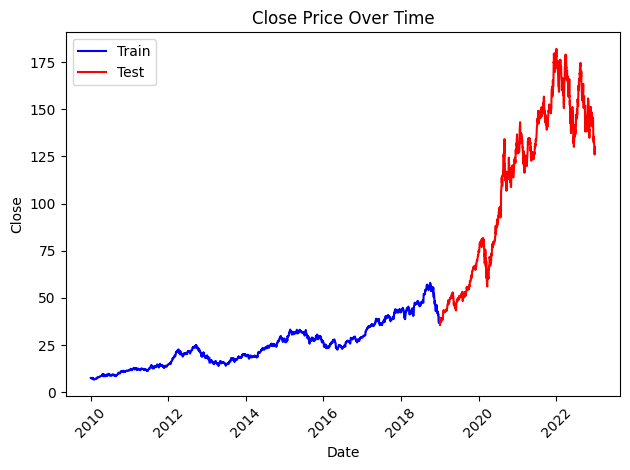

In [2]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
data = Data('AAPL',start_date,end_date,2019)
data.data_preprocess()

Running ring
GENERATION 0 START
Generation 0: Best fitness = 307.6420368840561 Average Fitness = 176.8126869979455
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 307.6420368840561 Average Fitness = 183.16693009674339
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 397.2596469224108 Average Fitness = 213.03914247514382
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 560.0444033647212 Average Fitness = 236.82848423568512
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 561.6347244621089 Average Fitness = 281.56001863739755
GENERATION 4 END
Running ring
GENERATION 0 START
Generation 0: Best fitness = 421.2523937391022 Average Fitness = 238.33376615663875
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 421.25239373910233 Average Fitness = 265.1970599379034
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 421.25239373910233 Average Fitness = 255.40964059292446
GENERATION 2 END
GENERATION 3 S

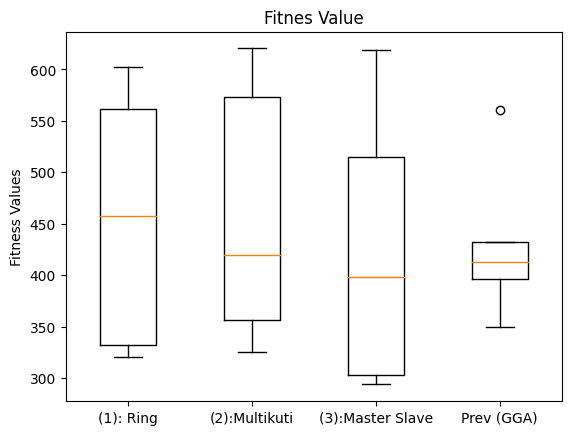

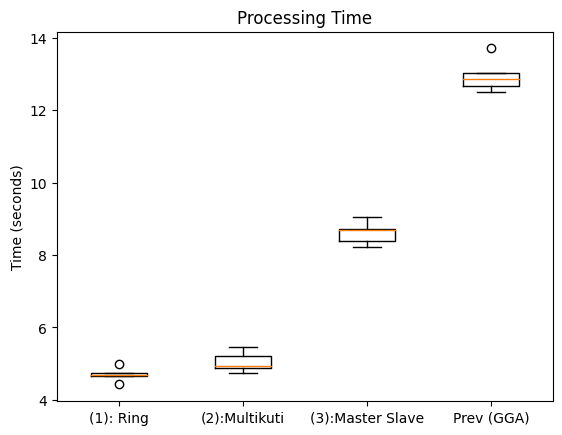

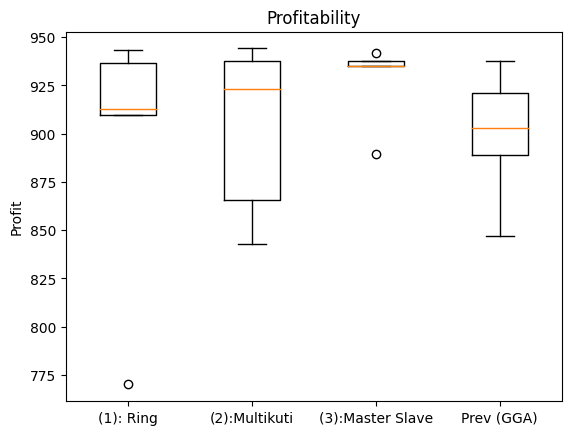

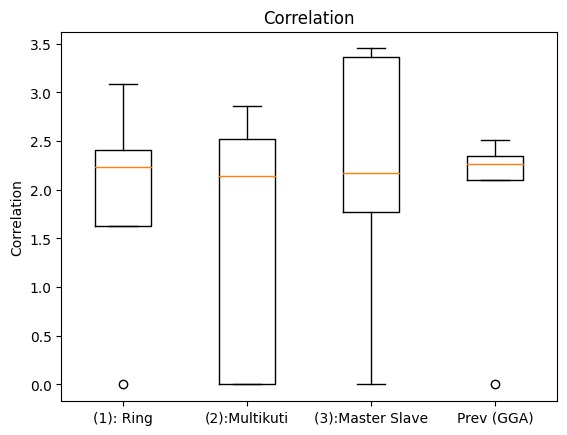

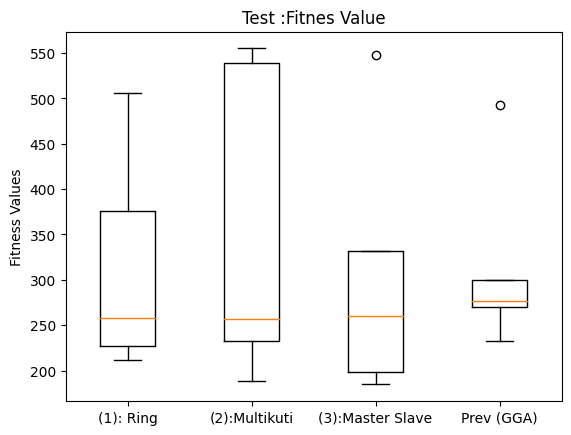

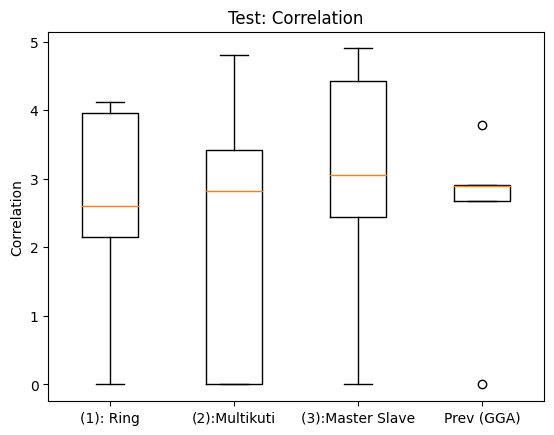

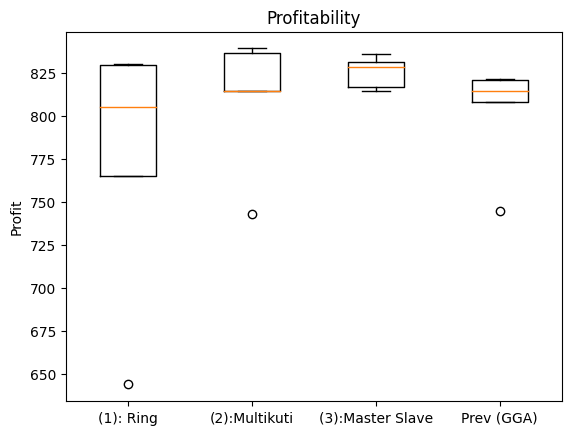

In [8]:
#total return training 
import matplotlib.pyplot as plt

fitness_values = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
test_fitness_values = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
speed_values =  {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
profit = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
test_profit = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
risk = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
test_risk = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
evolve_strategy =["ring", "multikuti","master_slave","gga"]

for i in evolve_strategy:
    for j in range(50):
        start = time.time()
        ga = IslandGGA(data=data.train_data,num_islands=8,m_iter=15,num_iter=50,pSize=200,r_cross=0.4,r_mut=0.1,strategies=data.strategies,evolve_strategy=i)
        ga.evolve()
        end = time.time()
        processing_time=end - start
        speed_values[i].append(processing_time)
        ### USE TRAIN DATA? 
        fitness_values[i].append(ga.globalBest.fitness_value)
        profit[i].append(ga.globalBest.profit)
        risk[i].append(ga.globalBest.corr)
        ### USE TEST DATA HERE? 
        ga.globalBest.calculate_chromosome_fitness(data.test_data,1000)
        test_fitness_values[i].append(ga.globalBest.fitness_value)
        test_profit[i].append(ga.globalBest.profit)
        test_risk[i].append(ga.globalBest.corr)



# Combine the fitness data into a list
fitness_data = [fitness_values[i] for i in  evolve_strategy]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(fitness_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Prev (GGA)'])

# Set the y-axis label
ax.set_ylabel('Fitness Values')

# Set the title of the plot
ax.set_title('Fitness Value')

# Show the plot
plt.show()

#### TIME PLOT
# Combine the time data into a list
speed_data = [speed_values[i] for i in  evolve_strategy]

# Create a time box plot
fig, ax = plt.subplots()
ax.boxplot(speed_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Prev (GGA)'])

# Set the y-axis label
ax.set_ylabel('Time (seconds)')

# Set the title of the plot
ax.set_title('Processing Time')

# Show the plot
plt.show()
#### profit
# Combine the profit data into a list
profit_data = [profit[i] for i in  evolve_strategy]

# Create a profit box plot
fig, ax = plt.subplots()
ax.boxplot(profit_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Prev (GGA)'])

# Set the y-axis label
ax.set_ylabel('Profit')

# Set the title of the plot
ax.set_title('Profitability')

# Show the plot
plt.show()
#### profit
# Combine the risk data into a list
risk_data = [risk[i] for i in  evolve_strategy]

# Create a risk box plot
fig, ax = plt.subplots()
ax.boxplot(risk_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Prev (GGA)'])

# Set the y-axis label
ax.set_ylabel('Correlation')

# Set the title of the plot
ax.set_title('Correlation')

# Show the plot
plt.show()
# Combine the test fitness data into a list
test_fitness_data = [test_fitness_values[i] for i in  evolve_strategy]

# Create a test fitness box plot
fig, ax = plt.subplots()
ax.boxplot(test_fitness_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Prev (GGA)'])

# Set the y-axis label
ax.set_ylabel('Fitness Values')

# Set the title of the plot
ax.set_title('Test :Fitness Value')

# Show the plot
plt.show()
#### test risk
# Combine the risk data into a list
test_risk_data = [test_risk[i] for i in  evolve_strategy]

# Create a risk box plot
fig, ax = plt.subplots()
ax.boxplot(test_risk_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Prev (GGA)'])

# Set the y-axis label
ax.set_ylabel('Correlation')

# Set the title of the plot
ax.set_title('Test: Correlation')
#### profit
# Combine the profit data into a list
test_profit_data = [test_profit[i] for i in  evolve_strategy]

# Create a test profit box plot
fig, ax = plt.subplots()
ax.boxplot(test_profit_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Prev (GGA)'])

# Set the y-axis label
ax.set_ylabel('Profit')

# Set the title of the plot
ax.set_title('Test : Profitability')

# Show the plot
plt.show()